In [47]:
using DrWatson
quickactivate(@__DIR__)

import Baysor as B
import CairoMakie as MK
import Colors
import CSV
import MultivariateStats
import PyPlot as Plt

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using Statistics
using StatsBase

MK.activate!(type="png");

In [4]:
# @time mol_df, gene_names = B.load_df(datadir("exp_raw/marioni_membrane/molecules_embryo1_5.csv"); 
@time mol_df, gene_names = B.load_df(datadir("exp_raw/marioni_membrane/tiles/molecules_embryo1_Pos1_2.csv"); 
    x_col=:x_global_affine, y_col=:y_global_affine, gene_col=:geneID);

@time seg_df = DataFrame!(CSV.File(datadir("exp_raw/marioni_membrane/segmentation_vertices.csv")));
rename!(seg_df, :segmentation_vertices_x_global_affine => :x, :segmentation_vertices_y_global_affine => :y);

seg_df = seg_df[in.(String.(seg_df.uniqueID), Ref(Set(mol_df.uniqueID))),:];

@time mol_df[!, :cell] = denserank(mol_df.uniqueID);

size(mol_df), size(seg_df)

 14.534046 seconds (26.16 M allocations: 1.337 GiB, 5.18% gc time, 82.60% compilation time)
  1.026715 seconds (427.14 k allocations: 108.723 MiB, 5.83% gc time, 18.66% compilation time)
  0.182283 seconds (230.41 k allocations: 15.029 MiB, 81.51% compilation time)


((81712, 11), (12569, 5))

In [5]:
polygons = [collect.(zip(g.x, g.y)) for g in groupby(seg_df, :uniqueID)];
polygons = [copy(hcat(p...)') for p in polygons];

In [6]:
@time pols_est = B.boundary_polygons(mol_df, mol_df.cell, grid_step=0.002, bandwidth=0.005);

 41.076517 seconds (55.26 M allocations: 3.170 GiB, 2.10% gc time)


In [71]:
B.append_confidence!(mol_df; nn_id=30);

┌ Warning: Only k-nn random field is supported for 3D data
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/triangulation.jl:30


In [74]:
@time neighb_cm = B.neighborhood_count_matrix(mol_df, 30);
@time color_transformation = B.gene_composition_transformation(neighb_cm, mol_df.confidence);
@time color_embedding = B.transform(color_transformation, neighb_cm);

  0.714840 seconds (898.95 k allocations: 595.122 MiB, 21.52% gc time)
 30.765050 seconds (5.25 M allocations: 1.320 GiB, 1.36% gc time, 9.35% compilation time)
  5.085686 seconds (8.88 M allocations: 763.561 MiB, 0.86% gc time)


In [76]:
@time mol_df[!,:ncv_color] = B.gene_composition_colors(color_embedding);

  0.095728 seconds (1.32 M allocations: 49.926 MiB, 26.27% compilation time)


In [7]:
# meta_df = DataFrame(String.(permutedims(hcat(split.(mol_df.uniqueID, '_')...))), [:embryo, :pos, :cell, :z]);

# B.plot_molecules(mol_df, color=B.shuffle_colors(meta_df.pos), colormap=:tab20c)
# B.plot_molecules(mol_df, annotation=meta_df.embryo)
# B.plot_molecules(mol_df, annotation=meta_df.pos)

In [78]:
p_df = @where(mol_df, :x .< 0.32, :x .> -0.05, :y .> -2.8);
@time p_pols = B.boundary_polygons(p_df, p_df.cell, grid_step=0.0004, bandwidth=0.002, dens_threshold=0.8, min_border_length=200);

  0.721516 seconds (892.52 k allocations: 124.284 MiB, 66.51% gc time)


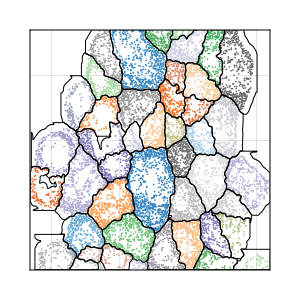

In [46]:
B.plot_molecules(p_df, p_pols, color=B.shuffle_colors(p_df.cell), colormap=:tab20c, markersize=1.7, size=(300, 300))

In [49]:
# Plt.scatter(p_df.x, p_df.y, c=p_df.cell)

In [57]:
bm_data = B.initialize_bmm_data(select(mol_df, Not(:z)); scale=0.02, min_molecules_per_cell=20, confidence_nn_id=0);

┌ Info: Initializing algorithm. Scale: 0.02, scale std: 0.005, initial #components: 8170, #molecules: 81712.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:235


In [58]:
B.bmm!(bm_data; n_iters=400, min_molecules_per_cell=20, assignment_history_depth=100, verbose=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/vpetukhov/.julia/packages/ProgressMeter/0ub8y/src/ProgressMeter.jl:474
Progress: 100%|█████████████████████████████████████████| Time: 0:02:15
  Iteration:        400
  Noise level, %:   7.27
  Num. components:  5966


In [80]:
p_df = @where(@transform(mol_df, cell_b=bm_data.assignment), :x .< 0.32, :x .> -0.05, :y .> -2.8);
@time p_pols_baysor = B.boundary_polygons(p_df, p_df.cell_b, grid_step=0.0004, bandwidth=0.002, dens_threshold=0.8, min_border_length=200, min_molecules_per_cell=20);

  1.262748 seconds (1.25 M allocations: 183.054 MiB, 45.00% gc time)


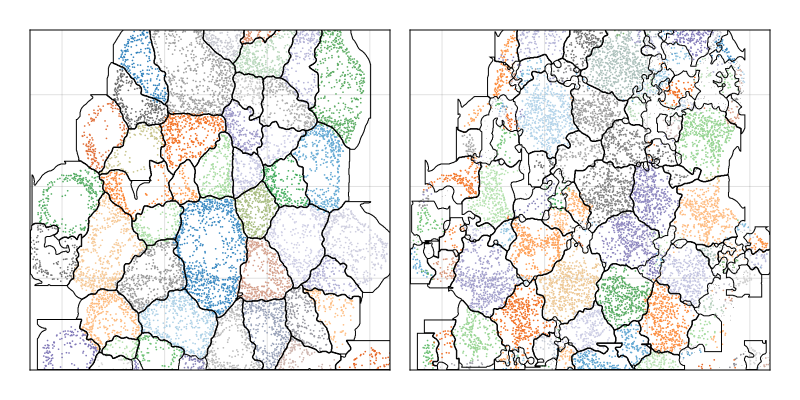

In [86]:
fig = MK.Figure(resolution=(800, 400))
fig[1,1] = MK.Axis(fig, xticklabelsvisible=false, yticklabelsvisible=false, xticksvisible=false, yticksvisible=false)
B.plot_molecules!(p_df, p_pols, color=B.shuffle_colors(p_df.cell), colormap=:tab20c, markersize=1.7)
# B.plot_molecules!(p_df, p_pols, color=:ncv_color, colormap=:tab20c, markersize=1.7)

fig[1,2] = MK.Axis(fig, xticklabelsvisible=false, yticklabelsvisible=false, xticksvisible=false, yticksvisible=false)
B.plot_molecules!(p_df, p_pols_baysor, color=B.shuffle_colors(p_df.cell_b), colormap=:tab20c, markersize=1.7, is_noise=(p_df.cell_b .== 0))
MK.save(plotsdir("outstanding_challenges/marioni_membrane.pdf"), fig)
fig